In [11]:
#Imports
import os
import math
import librosa
import librosa.display
import IPython.display as ipd

import pyAudioAnalysis
import pydub
import ffmpeg

from numpy import sin, cos, pi, linspace, arange, log10, absolute
from numpy.random import randn
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter, freqz, welch
from scipy.io.wavfile import read , write
from scipy.signal import spectrogram
from matplotlib import pyplot
from matplotlib.pyplot import ylabel, xlabel
from matplotlib.pyplot import plot, legend, show, grid, figure, savefig#, hold

In [17]:
os.chdir('C:/Users/lemos/PDS/TP')
os.getcwd()

'C:\\Users\\lemos\\PDS\\TP'

In [24]:
filename = 'audio/WD_data/N_rita_01_0.wav'
fs, audio1 = read(filename)
f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')
print('filename: ', filename)
print('Data Length (s): ',t[-1])
print('Sampling frequency (samples/s): ', fs)

#Playing Audio (Reproduce Audio)
ipd.Audio(filename)

filename:  audio/WD_data/N_rita_01_0.wav
Data Length (s):  0.6
Sampling frequency (samples/s):  44100


C:\Users\lemos\AppData\Local\Temp/ipykernel_1212/578031026.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pyplot.pcolormesh(t, f[:450], S1[:450][:])


Text(0, 0.5, 'frequency(Hz)')

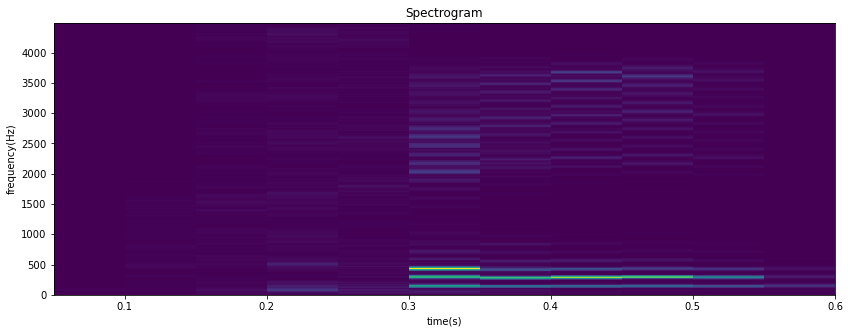

In [19]:
#Spectogram
#Spectrogram 
pyplot.rcParams['figure.figsize'] = 14,5
pyplot.pcolormesh(t, f[:450], S1[:450][:])
pyplot.title("Spectrogram")
xlabel('time(s)')
ylabel('frequency(Hz)')
#show()

In [21]:
#Filtro ButterWord

wn = 1500/(fs/2)
b3,a3 = butter(4, wn)
audio1_filt = lfilter(b3,a3,audio1)

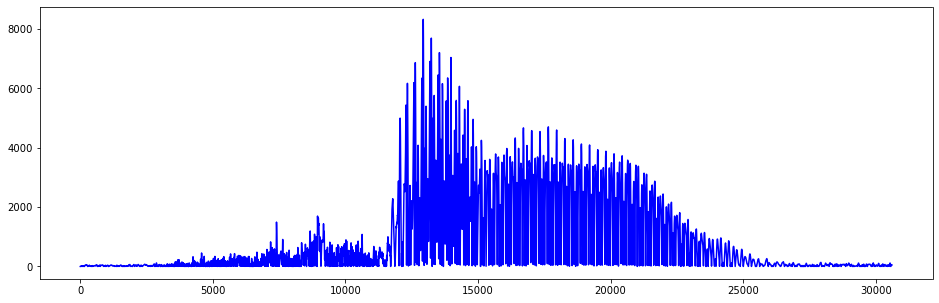

In [23]:
pyplot.rcParams['figure.figsize'] = 16,5
#plot(audio1,'r')
plot(absolute(audio1_filt),'b')

In [7]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

song = AudioSegment.from_wav(filename)

#Silence_len = 100
db = -30
segments = split_on_silence(song, min_silence_len = 100, silence_thresh = db)
while len(segments) != 2:
    db = db-1
    segments = split_on_silence(song, min_silence_len = 100, silence_thresh = db)

    
n = len(segments)
print("Size of List", n)


# Process each chunk with your parameters
for i, segment in enumerate(segments):

    # Export the audio chunk with new bitrate.
    print("Exporting chunk{0}.wav.".format(i))
    segment.export(
        "audio/data/chunk{0}.wav".format(i),
        bitrate = "192k",
        format = "wav"
    )

Size of List 2
Exporting chunk0.wav.
Exporting chunk1.wav.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pydub.playback import play

samples = segments[1].get_array_of_samples()
samples = np.array(samples)

filename = 'audio/data/chunk1.wav' 

ipd.Audio(filename)

In [11]:
fs, audio1 = read(filename)
f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')
print('filename: ', filename)
print('Data Length (s): ',t[-1])
print('Sampling frequency (samples/s): ', fs)

filename:  audio/data/chunk1.wav
Data Length (s):  0.55
Sampling frequency (samples/s):  44100


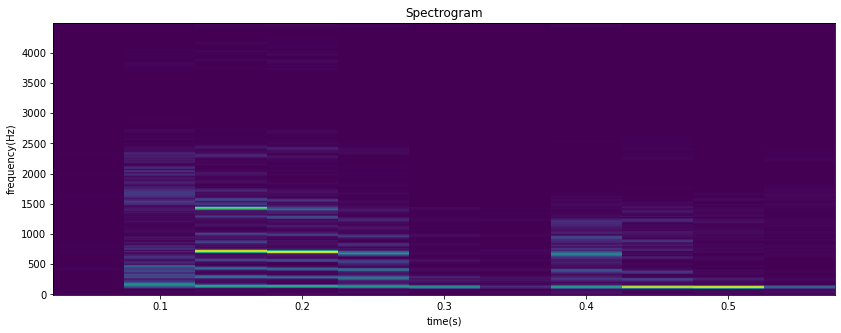

In [12]:
#Spectogram
pyplot.rcParams['figure.figsize'] = 14,5
pyplot.pcolormesh(t, f[:450], S1[:450][:])
pyplot.title("Spectrogram")
xlabel('time(s)')
ylabel('frequency(Hz)')
show()

In [13]:
import numpy as np

#Cepstrum and Power Spectrum

def real_spectrum(x, n=None):
# Compute the real cepstrum of a real sequence
#    x : ndarray
#        Real sequence to compute real cepstrum of.
#    n : {None, int}, optional
#        Length of the Fourier transform.
#    Returns

    spectrum = np.abs(np.fft.fft(x, n=n))**2

    return spectrum

max value index:  [77]
max value index:  [442]


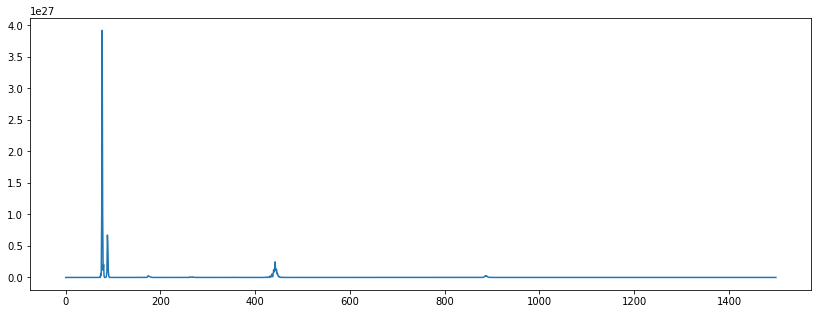

In [14]:
#Calculate Cepstrung and Power Spectrum
spec = real_spectrum(samples, n=None)
N = samples.shape[0]

#Power Specturm
power_spec = np.abs(spec[:N//2])**2
plt.plot(power_spec[0:1500])

#Zero Crossing Rate 
#zero_crosses_rate = np.nonzero(np.diff(samples > 0))[0]
#print(zero_crosses_rate)

index_H = np.where(power_spec == np.max(power_spec))
print('max value index: ', index_H[0])

index_L = np.where(power_spec == np.max(power_spec[400:1500])) #See how the hell i will do this
print('max value index: ', index_L[0])



In [15]:
from numpy import log as ln
from numpy import exp as exp
import math

def FtoM(f):
    f_Mel = 1125 * ln(1 + f/700)
    return f_Mel

def MtoF (m):
    f = 700 * (exp(m/1125)-1)
    return f

In [16]:
#MFCC
high_M = FtoM(int(index_H[0]))
low_M = FtoM(int(index_L[0]))

print(high_M)
print(low_M)

Filterbanks = linspace(high_M, low_M, 10)

print(Filterbanks)

117.40501723977322
550.6380620691198
[117.40501724 165.54202222 213.6790272  261.81603218 309.95303716
 358.09004214 406.22704713 454.36405211 502.50105709 550.63806207]


In [17]:
i = 0

for x in Filterbanks:
    Filterbanks[i] = MtoF(x)
    i += 1   
    
print(Filterbanks)

[ 77.         110.96816492 146.42131855 183.42438025 222.04510746
 262.35421979 304.42552847 348.33607159 394.16625508 442.        ]


In [16]:
i = 0
for x in Filterbanks:
    Filterbanks[i] = np.floor((spec[i]+1)*x/(fs/2)) ##?????? NFFT(Slides)
    i += 1

print(Filterbanks)

[ 5470584.   475091.  5602247.  2020596.   265150.  9296042.  2410386.
  3964967. 15147797.  3873538.]


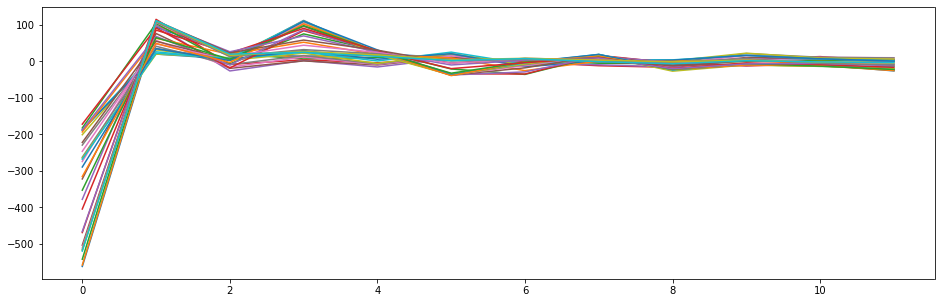

In [25]:
#MFCC

signal, sr = librosa.load(filename) 
signal.shape
mfccs = librosa.feature.mfcc(signal, n_mfcc=12, sr=sr)
plot(mfccs)
#print(mfccs)

In [3]:
#Visualie MFCC 
#pyplot.rcParams['figure.figsize'] = 14,5
plt.figure(figsize=(14,5))
librosa.display.specshow(mfccs,x_axis='time',sr=sr)
plt.colorbar(format="%+2f")
plt.show()

NameError: name 'plt' is not defined

In [20]:
#Calculate Delta and delta2 MFCCs

delta_mfccs=librosa.feature.delta(mfccs)
delta2_mfccs=librosa.feature.delta(mfccs, order=2)

In [21]:
delta_mfccs.shape

(13, 27)

In [22]:
mfccs.shape

(13, 27)

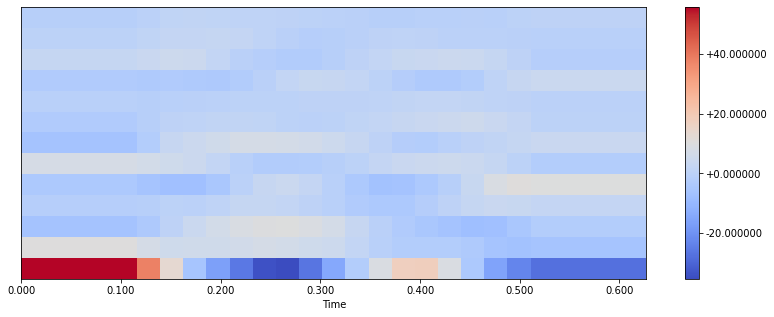

In [23]:
#First Derivative of MFCCs
plt.figure(figsize=(14,5))
librosa.display.specshow(delta_mfccs,x_axis='time',sr=sr)
plt.colorbar(format="%+2f")
plt.show()

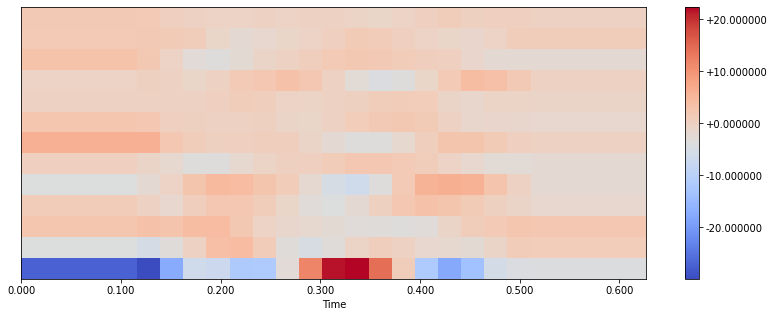

In [24]:
#Second Derivatives of MFCCs

plt.figure(figsize=(14,5))
librosa.display.specshow(delta2_mfccs,x_axis='time',sr=sr)
plt.colorbar(format="%+2f")
plt.show()